In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Experiment 1: Show times of different similarity metrics

In [2]:
# Load accuracy .csv and times.csv
time_path = '../../results/1_sim_metrics/mini_train/times.csv'
acc_path = '../../results/1_sim_metrics/accuracy.csv'

def get_max_n(row):
    return max(row['n_dets'],row['n_trks'])

def compute_fps(row):
    return 1000000000./row['time_ns']
    
time_df = pd.read_csv(time_path)
time_df['n_max'] = time_df.apply(get_max_n, axis=1)
time_df['fps'] = time_df.apply(compute_fps, axis=1)
acc_df = pd.read_csv(acc_path)

split='mini_train'
split_df = acc_df[acc_df['split']==split]

In [3]:
dist_time_df = time_df[time_df['config'].str.contains("_dist")]
iou_time_df = time_df[time_df['config'].str.contains("_iou3d")]
giou_time_df = time_df[time_df['config'].str.contains("_giou3d")]

dist
0.025111168021671824
39.8229185968954
0.571158291
1.7508281255082052
323

iou3d
0.7859217021486068
1.2723913810575929
3.435672333
0.2910638451737359
323

giou3d
2.6959052713560387
0.37093291467804473
12.333493052
0.08108003108153046
323



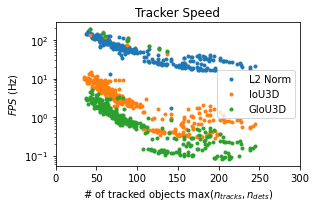

In [5]:

# New plot, speed vs n on log scale
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(4.5,3.)) # , gridspec_kw={'width_ratios': [2, 1]}
axs.scatter(dist_time_df['n_max'],dist_time_df['fps'],marker='.')
axs.scatter(iou_time_df['n_max'],iou_time_df['fps'],marker='.')
axs.scatter(giou_time_df['n_max'],giou_time_df['fps'],marker='.')
axs.set_xlim([0,300])
axs.set_title('Tracker Speed')
axs.set_xlabel('# of tracked objects max($n_{tracks},n_{dets}$)')
axs.set_ylabel('$FPS$ (Hz)')
axs.set_yscale('log')
axs.legend(['L2 Norm','IoU3D','GIoU3D'])


plt.savefig('nuscenes_results_1.png')

print("dist")
print(np.mean(dist_time_df['time_ns']/1000000000))
print(1000000000/np.mean(dist_time_df['time_ns']))
print(np.max(dist_time_df['time_ns']/(1000000000)))
print(1000000000/np.max(dist_time_df['time_ns']))
# print(np.mean(dist_time_df['time_ns']/(dist_time_df['n_max']*1000000000)))
# print(np.max(dist_time_df['time_ns']/(dist_time_df['n_max']*1000000000)))
print(len(dist_time_df['time_ns']))
print()

print("iou3d")
print(np.mean(iou_time_df['time_ns']/1000000000))
print(1000000000/(np.mean(iou_time_df['time_ns'])))
print(np.max(iou_time_df['time_ns']/(1000000000)))
print(1000000000./(np.max(iou_time_df['time_ns'])))
# print(np.mean(iou_time_df['time_ns']/(iou_time_df['n_max']*1000000000)))
# print(np.max(iou_time_df['time_ns']/(iou_time_df['n_max']*1000000000)))
print(len(iou_time_df['time_ns']))
print()

print("giou3d")
print(np.mean(giou_time_df['time_ns']/1000000000))
print(1000000000/(np.mean(giou_time_df['time_ns'])))
print(np.max(giou_time_df['time_ns']/(1000000000)))
print(1000000000/(np.max(giou_time_df['time_ns'])))
# print(np.mean(giou_time_df['time_ns']/(giou_time_df['n_max']*1000000000)))
# print(np.max(giou_time_df['time_ns']/(giou_time_df['n_max']*1000000000)))
print(len(giou_time_df['time_ns']))
print()

# Final Plot 2: Increase in AMOTA, delta T for process model/matching/yaw corr selection

In [9]:
# Load accuracy .csv and times.csv
time_path = '../../results/2_match_yc_model/mini_train/times.csv'
acc_path = '../../results/2_match_yc_model/mini_accuracy.csv'

def get_max_n(row):
    return max(row['n_dets'],row['n_trks'])
def compute_fps(row):
    return 1000000000./row['time_ns']
    
time_df = pd.read_csv(time_path)
time_df['n_max'] = time_df.apply(get_max_n, axis=1)
time_df['fps'] = time_df.apply(compute_fps, axis=1)
acc_df = pd.read_csv(acc_path)

split='mini_train'
split_df = acc_df[acc_df['split']==split]

In [10]:
# Get all indices of yc, and no_yc
yc_acc_df = split_df[['_yc_' in row for row in split_df['exp_config']]]
noyc_acc_df = split_df[['_noyc_' in row for row in split_df['exp_config']]]
yc_time_df = time_df[time_df['config'].str.contains("_yc")]
noyc_time_df = time_df[time_df['config'].str.contains("_noyc")]

assert(len(yc_acc_df)==len(noyc_acc_df))

In [11]:
# Get all indices of hungarian and greedy
hungar_acc_df = split_df[['hungar' in row for row in split_df['exp_config']]]
greedy_acc_df = split_df[['greedy' in row for row in split_df['exp_config']]]
hungar_time_df = time_df[time_df['config'].str.contains("hungar")]
greedy_time_df = time_df[time_df['config'].str.contains("greedy")]

assert(len(hungar_acc_df)==len(greedy_acc_df))

In [12]:
# Get all indices of yc, and no_yc
cvcy_acc_df = split_df[['_cvcy_c' in row for row in split_df['exp_config']]]
cvcyobj_acc_df = split_df[['_cvcy_obj_c' in row for row in split_df['exp_config']]]
ack_acc_df = split_df[['_ack_' in row for row in split_df['exp_config']]]
cvcy_time_df = time_df[time_df['config'].str.contains("_cvcy_c")]
cvcyobj_time_df = time_df[time_df['config'].str.contains("_cvcy_obj_c")]
ack_time_df = time_df[time_df['config'].str.contains("_ack_")]

assert(len(cvcy_acc_df)==len(ack_acc_df))

In [13]:
# Compute average and per-class AMOTA, plus mean/min FPS for yc vs. no YC

print('************* yc')
print("AMOTA - all: %s" % np.mean(yc_acc_df['amota']))
print("AMOTA - bike: %s" % np.mean(yc_acc_df['bicycle_amota']))
print("AMOTA - bus: %s" % np.mean(yc_acc_df['bus_amota']))
print("AMOTA - car: %s" % np.mean(yc_acc_df['car_amota']))
print("AMOTA - moto: %s" % np.mean(yc_acc_df['moto_amota']))
print("AMOTA - ped: %s" % np.mean(yc_acc_df['ped_amota']))
print("AMOTA - trlr: %s" % np.mean(yc_acc_df['trailer_amota']))
print("AMOTA - truck: %s" % np.mean(yc_acc_df['truck_amota']))
print("Mean FPS: %s" % np.mean(yc_time_df['fps']))
print("Min FPS: %s" % np.min(yc_time_df['fps']))
print()

print('************* NO yc')
print("AMOTA - all: %s" % np.mean(noyc_acc_df['amota']))
print("AMOTA - bike: %s" % np.mean(noyc_acc_df['bicycle_amota']))
print("AMOTA - bus: %s" % np.mean(noyc_acc_df['bus_amota']))
print("AMOTA - car: %s" % np.mean(noyc_acc_df['car_amota']))
print("AMOTA - moto: %s" % np.mean(noyc_acc_df['moto_amota']))
print("AMOTA - ped: %s" % np.mean(noyc_acc_df['ped_amota']))
print("AMOTA - trlr: %s" % np.mean(noyc_acc_df['trailer_amota']))
print("AMOTA - truck: %s" % np.mean(noyc_acc_df['truck_amota']))
print("Mean FPS: %s" % np.mean(noyc_time_df['fps']))
print("Min FPS: %s" % np.min(noyc_time_df['fps']))
print()

print('************* Hungarian')
print("AMOTA - all: %s" % np.mean(hungar_acc_df['amota']))
print("AMOTA - bike: %s" % np.mean(hungar_acc_df['bicycle_amota']))
print("AMOTA - bus: %s" % np.mean(hungar_acc_df['bus_amota']))
print("AMOTA - car: %s" % np.mean(hungar_acc_df['car_amota']))
print("AMOTA - moto: %s" % np.mean(hungar_acc_df['moto_amota']))
print("AMOTA - ped: %s" % np.mean(hungar_acc_df['ped_amota']))
print("AMOTA - trlr: %s" % np.mean(hungar_acc_df['trailer_amota']))
print("AMOTA - truck: %s" % np.mean(hungar_acc_df['truck_amota']))
print("Mean FPS: %s" % np.mean(hungar_time_df['fps']))
print("Min FPS: %s" % np.min(hungar_time_df['fps']))
print()

print('************* Greedy')
print("AMOTA - all: %s" % np.mean(greedy_acc_df['amota']))
print("AMOTA - bike: %s" % np.mean(greedy_acc_df['bicycle_amota']))
print("AMOTA - bus: %s" % np.mean(greedy_acc_df['bus_amota']))
print("AMOTA - car: %s" % np.mean(greedy_acc_df['car_amota']))
print("AMOTA - moto: %s" % np.mean(greedy_acc_df['moto_amota']))
print("AMOTA - ped: %s" % np.mean(greedy_acc_df['ped_amota']))
print("AMOTA - trlr: %s" % np.mean(greedy_acc_df['trailer_amota']))
print("AMOTA - truck: %s" % np.mean(greedy_acc_df['truck_amota']))
print("Mean FPS: %s" % np.mean(greedy_time_df['fps']))
print("Min FPS: %s" % np.min(greedy_time_df['fps']))
print()

print('************* CVCY (tracker)')
print("AMOTA - all: %s" % np.mean(cvcy_acc_df['amota']))
print("AMOTA - bike: %s" % np.mean(cvcy_acc_df['bicycle_amota']))
print("AMOTA - bus: %s" % np.mean(cvcy_acc_df['bus_amota']))
print("AMOTA - car: %s" % np.mean(cvcy_acc_df['car_amota']))
print("AMOTA - moto: %s" % np.mean(cvcy_acc_df['moto_amota']))
print("AMOTA - ped: %s" % np.mean(cvcy_acc_df['ped_amota']))
print("AMOTA - trlr: %s" % np.mean(cvcy_acc_df['trailer_amota']))
print("AMOTA - truck: %s" % np.mean(cvcy_acc_df['truck_amota']))
print("Mean FPS: %s" % np.mean(cvcy_time_df['fps']))
print("Min FPS: %s" % np.min(cvcy_time_df['fps']))
print()

print('************* CVCY (obj)')
print("AMOTA - all: %s" % np.mean(cvcyobj_acc_df['amota']))
print("AMOTA - bike: %s" % np.mean(cvcyobj_acc_df['bicycle_amota']))
print("AMOTA - bus: %s" % np.mean(cvcyobj_acc_df['bus_amota']))
print("AMOTA - car: %s" % np.mean(cvcyobj_acc_df['car_amota']))
print("AMOTA - moto: %s" % np.mean(cvcyobj_acc_df['moto_amota']))
print("AMOTA - ped: %s" % np.mean(cvcyobj_acc_df['ped_amota']))
print("AMOTA - trlr: %s" % np.mean(cvcyobj_acc_df['trailer_amota']))
print("AMOTA - truck: %s" % np.mean(cvcyobj_acc_df['truck_amota']))
print("Mean FPS: %s" % np.mean(cvcyobj_time_df['fps']))
print("Min FPS: %s" % np.min(cvcyobj_time_df['fps']))
print()

print('************* Ackermann')
print("AMOTA - all: %s" % np.mean(ack_acc_df['amota']))
print("AMOTA - bike: %s" % np.mean(ack_acc_df['bicycle_amota']))
print("AMOTA - bus: %s" % np.mean(ack_acc_df['bus_amota']))
print("AMOTA - car: %s" % np.mean(ack_acc_df['car_amota']))
print("AMOTA - moto: %s" % np.mean(ack_acc_df['moto_amota']))
print("AMOTA - ped: %s" % np.mean(ack_acc_df['ped_amota']))
print("AMOTA - trlr: %s" % np.mean(ack_acc_df['trailer_amota']))
print("AMOTA - truck: %s" % np.mean(ack_acc_df['truck_amota']))
print("Mean FPS: %s" % np.mean(ack_time_df['fps']))
print("Min FPS: %s" % np.min(ack_time_df['fps']))
print()



************* yc
AMOTA - all: 0.48678104575163383
AMOTA - bike: 0.31944117647058834
AMOTA - bus: 0.5926078431372546
AMOTA - car: 0.46921568627451005
AMOTA - moto: 0.2616274509803921
AMOTA - ped: 0.614130718954248
AMOTA - trlr: 0.7740882352941211
AMOTA - truck: 0.3765588235294117
Mean FPS: 83.29408686711092
Min FPS: 7.076147019549873

************* NO yc
AMOTA - all: 0.48742156862745084
AMOTA - bike: 0.319748366013072
AMOTA - bus: 0.5929575163398694
AMOTA - car: 0.46926797385620905
AMOTA - moto: 0.26134967320261404
AMOTA - ped: 0.6092352941176469
AMOTA - trlr: 0.7742385620915067
AMOTA - truck: 0.38516666666666666
Mean FPS: 83.6895234299883
Min FPS: 6.958896622960203

************* Hungarian
AMOTA - all: 0.4605490196078432
AMOTA - bike: 0.3134313725490199
AMOTA - bus: 0.5755718954248366
AMOTA - car: 0.4080196078431372
AMOTA - moto: 0.24399999999999986
AMOTA - ped: 0.5733660130718953
AMOTA - trlr: 0.7740294117647091
AMOTA - truck: 0.33549346405228736
Mean FPS: 87.72858094780739
Min FPS: 6

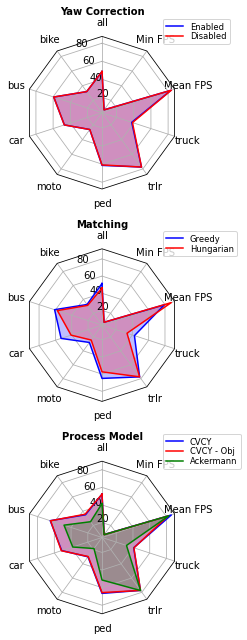

In [14]:
# RADAR PLOT
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta



spoke_labels =['all','bike','bus','car','moto','ped','trlr','truck','Mean FPS','Min FPS']
yc_data = [[np.mean(yc_acc_df['amota'])*100,
             np.mean(yc_acc_df['bicycle_amota'])*100,
             np.mean(yc_acc_df['bus_amota'])*100,
             np.mean(yc_acc_df['car_amota'])*100,
             np.mean(yc_acc_df['moto_amota'])*100,
             np.mean(yc_acc_df['ped_amota'])*100,
             np.mean(yc_acc_df['trailer_amota'])*100,
             np.mean(yc_acc_df['truck_amota'])*100,
             np.mean(yc_time_df['fps']),
             np.min(yc_time_df['fps'])],
            [np.mean(noyc_acc_df['amota'])*100,
             np.mean(noyc_acc_df['bicycle_amota'])*100,
             np.mean(noyc_acc_df['bus_amota'])*100,
             np.mean(noyc_acc_df['car_amota'])*100,
             np.mean(noyc_acc_df['moto_amota'])*100,
             np.mean(noyc_acc_df['ped_amota'])*100,
             np.mean(noyc_acc_df['trailer_amota'])*100,
             np.mean(noyc_acc_df['truck_amota'])*100,
             np.mean(noyc_time_df['fps']),
             np.min(noyc_time_df['fps'])]]

match_data = [[np.mean(greedy_acc_df['amota'])*100,
             np.mean(greedy_acc_df['bicycle_amota'])*100,
             np.mean(greedy_acc_df['bus_amota'])*100,
             np.mean(greedy_acc_df['car_amota'])*100,
             np.mean(greedy_acc_df['moto_amota'])*100,
             np.mean(greedy_acc_df['ped_amota'])*100,
             np.mean(greedy_acc_df['trailer_amota'])*100,
             np.mean(greedy_acc_df['truck_amota'])*100,
             np.mean(greedy_time_df['fps']),
             np.min(greedy_time_df['fps'])],
             [np.mean(hungar_acc_df['amota'])*100,
             np.mean(hungar_acc_df['bicycle_amota'])*100,
             np.mean(hungar_acc_df['bus_amota'])*100,
             np.mean(hungar_acc_df['car_amota'])*100,
             np.mean(hungar_acc_df['moto_amota'])*100,
             np.mean(hungar_acc_df['ped_amota'])*100,
             np.mean(hungar_acc_df['trailer_amota'])*100,
             np.mean(hungar_acc_df['truck_amota'])*100,
             np.mean(hungar_time_df['fps']),
             np.min(hungar_time_df['fps'])]]

proc_model_data = [[np.mean(cvcy_acc_df['amota'])*100,
             np.mean(cvcy_acc_df['bicycle_amota'])*100,
             np.mean(cvcy_acc_df['bus_amota'])*100,
             np.mean(cvcy_acc_df['car_amota'])*100,
             np.mean(cvcy_acc_df['moto_amota'])*100,
             np.mean(cvcy_acc_df['ped_amota'])*100,
             np.mean(cvcy_acc_df['trailer_amota'])*100,
             np.mean(cvcy_acc_df['truck_amota'])*100,
             np.mean(cvcy_time_df['fps']),
             np.min(cvcy_time_df['fps'])],
             [np.mean(cvcyobj_acc_df['amota'])*100,
             np.mean(cvcyobj_acc_df['bicycle_amota'])*100,
             np.mean(cvcyobj_acc_df['bus_amota'])*100,
             np.mean(cvcyobj_acc_df['car_amota'])*100,
             np.mean(cvcyobj_acc_df['moto_amota'])*100,
             np.mean(cvcyobj_acc_df['ped_amota'])*100,
             np.mean(cvcyobj_acc_df['trailer_amota'])*100,
             np.mean(cvcyobj_acc_df['truck_amota'])*100,
             np.mean(cvcyobj_time_df['fps']),
             np.min(cvcyobj_time_df['fps'])],
             [np.mean(ack_acc_df['amota'])*100,
             np.mean(ack_acc_df['bicycle_amota'])*100,
             np.mean(ack_acc_df['bus_amota'])*100,
             np.mean(ack_acc_df['car_amota'])*100,
             np.mean(ack_acc_df['moto_amota'])*100,
             np.mean(ack_acc_df['ped_amota'])*100,
             np.mean(ack_acc_df['trailer_amota'])*100,
             np.mean(ack_acc_df['truck_amota'])*100,
             np.mean(ack_time_df['fps']),
             np.min(ack_time_df['fps'])]]
                             

N = 10
theta = radar_factory(N, frame='polygon')


fig, axs = plt.subplots(figsize=(4.5, 9), nrows=3, tight_layout=True,ncols=1,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

colors = ['b', 'r', 'g']

# Yaw correction
axs[0].set_rgrids([20, 40, 60, 80])
axs[0].set_title('Yaw Correction', weight='bold', size='medium', position=(0.5, 1.1),
             horizontalalignment='center', verticalalignment='center')

for d, color in zip(yc_data, colors):
    axs[0].plot(theta, d, color=color)
    axs[0].fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
axs[0].set_varlabels(spoke_labels)

legend = axs[0].legend(('Enabled', 'Disabled'), loc=(0.9, .95), labelspacing=0.1, fontsize='small')

# Matching
axs[1].set_rgrids([20, 40, 60, 80])
axs[1].set_title('Matching', weight='bold', size='medium', position=(0.5, 1.1),
             horizontalalignment='center', verticalalignment='center')

for d, color in zip(match_data, colors):
    axs[1].plot(theta, d, color=color)
    axs[1].fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
axs[1].set_varlabels(spoke_labels)

legend = axs[1].legend(('Greedy', 'Hungarian'), loc=(0.9, .95), labelspacing=0.1, fontsize='small')

# Proc model
axs[2].set_rgrids([20, 40, 60, 80])
axs[2].set_title('Process Model', weight='bold', size='medium', position=(0.5, 1.1),
             horizontalalignment='center', verticalalignment='center')

for d, color in zip(proc_model_data, colors):
    axs[2].plot(theta, d, color=color)
    axs[2].fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
axs[2].set_varlabels(spoke_labels)

legend = axs[2].legend(('CVCY', 'CVCY - Obj', 'Ackermann'), loc=(0.9, .95), labelspacing=0.1, fontsize='small')


plt.savefig('nuscenes_results_2.png')
plt.show()




# Experiment 3: Final validation/test speed results

In [26]:
val_time_path = '../../results/3b_best/val/times.csv'
val_time_df = pd.read_csv(val_time_path)

for cfg in val_time_df['config'].unique():
    print(cfg)
    print("Mean comp time: %s" % (np.mean(val_time_df[val_time_df['config']==cfg]['time_ns'])/1000000000))
    print("Max comp time: %s" % (np.max(val_time_df[val_time_df['config']==cfg]['time_ns'])/1000000000))
    print("Mean FPS: %s" % (1000000000/np.mean(val_time_df[val_time_df['config']==cfg]['time_ns'])))
    print("Min FPS: %s" % (1000000000/np.max(val_time_df[val_time_df['config']==cfg]['time_ns'])))
    print()

greedy_bestdist_bestmodel_bestmgmt
Mean comp time: 0.015384368613557069
Max comp time: 0.554820018
Mean FPS: 65.0010426244452
Min FPS: 1.8023863010652943

greedy_iou3d_bestmodel_bestmgmt
Mean comp time: 0.48467771695098855
Max comp time: 4.062141478
Mean FPS: 2.063226686571856
Min FPS: 0.24617557153434033

greedy_giou3d_bestmodel_bestmgmt
Mean comp time: 1.2345842120671209
Max comp time: 13.125605179
Mean FPS: 0.8099892986041465
Min FPS: 0.07618696329521828



In [25]:
test_time_path = '../../results/3b_best/test/times.csv'
test_time_df = pd.read_csv(test_time_path)

for cfg in test_time_df['config'].unique():
    print(cfg)
    print("Mean comp time: %s" % (np.mean(test_time_df[test_time_df['config']==cfg]['time_ns'])/1000000000))
    print("Max comp time: %s" % (np.max(test_time_df[test_time_df['config']==cfg]['time_ns'])/1000000000))
    print("Mean FPS: %s" % (1000000000/np.mean(test_time_df[test_time_df['config']==cfg]['time_ns'])))
    print("Min FPS: %s" % (1000000000/np.max(test_time_df[test_time_df['config']==cfg]['time_ns'])))
    print()

greedy_bestdist_bestmodel_bestmgmt
Mean comp time: 0.016123545934587216
Max comp time: 0.604146683
Mean FPS: 62.02109660349978
Min FPS: 1.6552271627716608

